In [14]:
import pandas as pd
import numpy as np

def create_time_features(df, order_time_col='order_create_time', session_end_col='session_end_time'):
    """
    Создает новые временные признаки на основе колонок с временными метками.
    
    Параметры:
    df - DataFrame с данными
    order_time_col - название колонки с временем создания заказа (timestamp)
    session_end_col - название колонки с временем окончания сессии (timestamp)
    
    Возвращает:
    DataFrame с добавленными новыми признаками
    """
    # Создаем копию DataFrame чтобы избежать предупреждений
    df = df.copy()
    
    # Преобразуем колонки в datetime, если они еще не в этом формате
    df[order_time_col] = pd.to_datetime(df[order_time_col])
    df[session_end_col] = pd.to_datetime(df[session_end_col])
    
    # 1. Разница между окончанием сессии и созданием заказа (в секундах)
    df['time_to_order_seconds'] = (df[session_end_col] - df[order_time_col]).dt.total_seconds()
    
    # 2. Признаки времени создания заказа
    df['order_hour'] = df[order_time_col].dt.hour
    df['order_day_of_week'] = df[order_time_col].dt.dayofweek  # 0-понедельник, 6-воскресенье
    df['order_day_of_month'] = df[order_time_col].dt.day
    df['order_month'] = df[order_time_col].dt.month
    df['order_week_of_year'] = df[order_time_col].dt.isocalendar().week
    df['order_is_weekend'] = df[order_time_col].dt.dayofweek >= 5
    
    # 3. Признаки времени окончания сессии
    df['session_end_hour'] = df[session_end_col].dt.hour
    df['session_end_day_of_week'] = df[session_end_col].dt.dayofweek
    df['session_end_day_of_month'] = df[session_end_col].dt.day
    df['session_end_month'] = df[session_end_col].dt.month
    df['session_end_week_of_year'] = df[session_end_col].dt.isocalendar().week
    df['session_end_is_weekend'] = df[session_end_col].dt.dayofweek >= 5
    
    # 4. Разница во времени в разных единицах
    df['time_to_order_minutes'] = df['time_to_order_seconds'] / 60
    df['time_to_order_hours'] = df['time_to_order_seconds'] / 3600
    
    # 5. Временные категории (утро/день/вечер/ночь)
    bins = [-1, 6, 12, 18, 23]
    labels = ['night', 'morning', 'afternoon', 'evening']
    df['order_time_of_day'] = pd.cut(df['order_hour'], bins=bins, labels=labels)
    df['session_end_time_of_day'] = pd.cut(df['session_end_hour'], bins=bins, labels=labels)
    
    # 6. Является ли заказ сделан в тот же день, что и сессия
    df['same_day_order'] = df[order_time_col].dt.date == df[session_end_col].dt.date
    
    # 7. Сезонность (времена года)
    def get_season(month):
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'autumn'
    
    df['order_season'] = df['order_month'].apply(get_season)
    df['session_end_season'] = df['session_end_month'].apply(get_season)
    
    return df

In [15]:
import pickle
import joblib
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Загрузка LightGBM (из pickle)
with open('models/lgb_944.pkl', 'rb') as f:
    lgb_model = pickle.load(f)  # или joblib.load(f), в зависимости от способа сохранения

# Загрузка CatBoost (нативный формат)
cb_model = CatBoostClassifier()
cb_model.load_model('models/catboost_model.cbm')

In [16]:
tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

target = tr.target
tr = tr.drop(columns='target')

order_id = tst.order_id
tst = tst.drop(columns='order_id')


tr = create_time_features(tr)
tr = tr.drop(columns=['order_create_time', 'session_end_time'])

tst = create_time_features(tst)
tst = tst.drop(columns=['order_create_time', 'session_end_time'])

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Категориальные колонки
cat_cols = tr.select_dtypes(include=['category', 'object']).columns.tolist()

# Приведение типов
for col in cat_cols:
    tr[col] = tr[col].astype('category')
    tst[col] = tst[col].astype('category')

# Сохраняем категории
cat_categories = {col: tr[col].cat.categories.tolist() for col in cat_cols}

# Явно задаем категории и обрабатываем пропуски
for col in cat_cols:
    if 'missing' not in tr[col].cat.categories:
        tr[col] = tr[col].cat.add_categories(['missing'])
        tst[col] = tst[col].cat.add_categories(['missing'])

    tr[col] = tr[col].fillna('missing')
    tst[col] = tst[col].fillna('missing')

# Параметры моделей
lgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.05,
    'random_state': 42
}

cb_params = {
    'iterations': 100,
    'learning_rate': 0.05,
    'random_state': 42,
    'verbose': 0
}

# Массивы для out-of-fold предсказаний
oof_lgb = np.zeros(len(tr))
oof_cb = np.zeros(len(tr))
oof_meta = np.zeros(len(tr))
test_pred = []

# Кросс-валидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(tr, target)):
    print(f"FOLD {fold + 1}")

    X_train, X_val = tr.iloc[train_idx], tr.iloc[val_idx]
    y_train, y_val = target.iloc[train_idx], target.iloc[val_idx]

    # Катфичи по индексам для CatBoost
    cat_features_idx = [X_train.columns.get_loc(col) for col in cat_cols]

    # Базовые модели
    lgb_model_fold = LGBMClassifier(**lgb_params)
    lgb_model_fold.fit(X_train, y_train)

    cb_model_fold = CatBoostClassifier(**cb_params)
    cb_model_fold.fit(X_train, y_train, cat_features=cat_features_idx)

    lgb_val_pred = lgb_model_fold.predict(X_val)
    cb_val_pred = cb_model_fold.predict_proba(X_val)[:, 1]

    # Сохраняем OOF предсказания
    oof_lgb[val_idx] = lgb_val_pred
    oof_cb[val_idx] = cb_val_pred

    # Стекинг вход
    stack_input = np.column_stack([lgb_val_pred, cb_val_pred])

    # Калиброванная логрегрессия
    base_logreg = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', random_state=42)
    calibrated = CalibratedClassifierCV(base_logreg, method='isotonic', cv=3)
    calibrated.fit(stack_input, y_val)

    # Предсказание на валидации
    oof_meta[val_idx] = calibrated.predict_proba(stack_input)[:, 1]

    # Предсказания на тесте
    lgb_test_pred = lgb_model_fold.predict(tst)
    cb_test_pred = cb_model_fold.predict_proba(tst)[:, 1]
    test_stack = np.column_stack([lgb_test_pred, cb_test_pred])
    test_pred.append(calibrated.predict_proba(test_stack)[:, 1])

# Финальные предсказания
stacked_pred = np.mean(test_pred, axis=0)

# ROC-AUC
train_auc = roc_auc_score(target, oof_meta)
print(f"ROC-AUC по всей выборке: {train_auc:.4f}")

# Сохранение сабмита
submission = pd.DataFrame({
    'order_id': order_id,
    'target': stacked_pred
})
submission.to_csv('stacked_submission_cv.csv', index=False)


FOLD 1
[LightGBM] [Info] Number of positive: 29679, number of negative: 53997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1576
[LightGBM] [Info] Number of data points in the train set: 83676, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354690 -> initscore=-0.598489
[LightGBM] [Info] Start training from score -0.598489
FOLD 2
[LightGBM] [Info] Number of positive: 29679, number of negative: 53997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1576
[LightGBM] [Info] Number of data points in the train set: 83676, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354690 -> initscore=-0.598489
[LightGBM] [Info] Start training from score -0.59848

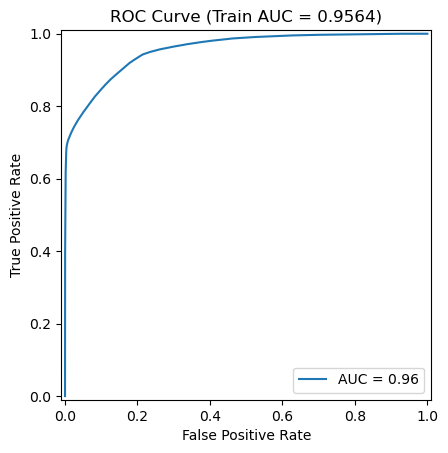

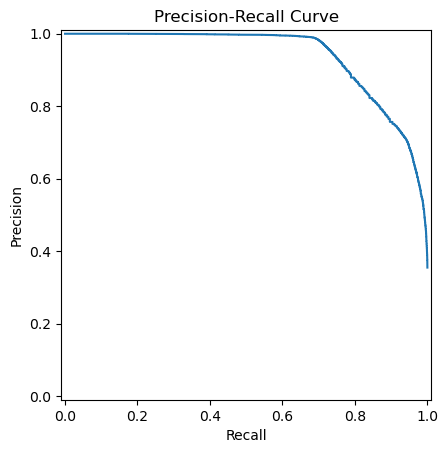

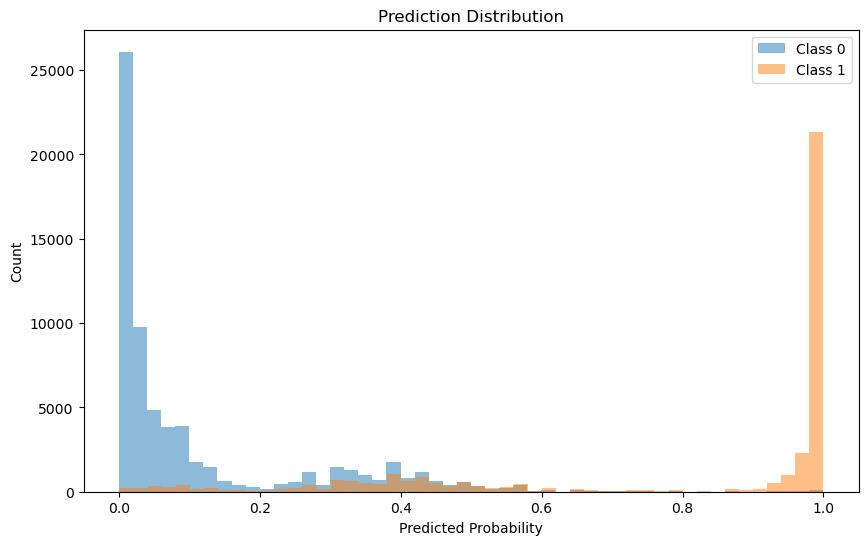

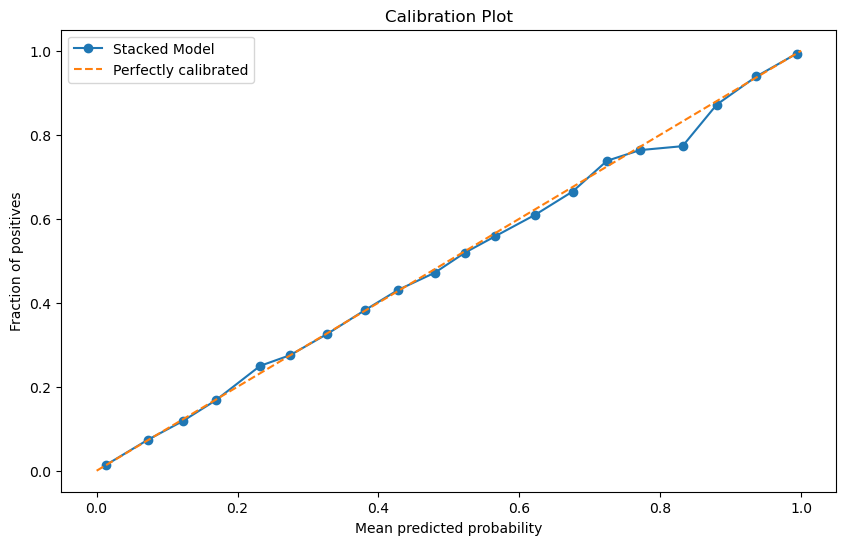

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.calibration import calibration_curve

# Подготовка данных
y_true = target
y_pred = oof_meta

# 1. ROC-кривая
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(y_true, y_pred))
roc_display.plot()
plt.title(f'ROC Curve (Train AUC = {roc_display.roc_auc:.4f})')
plt.show()

# 2. Precision-Recall кривая
precision, recall, _ = precision_recall_curve(y_true, y_pred)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()
plt.title('Precision-Recall Curve')
plt.show()

# 3. Распределение предсказаний
plt.figure(figsize=(10, 6))
plt.hist(y_pred[y_true == 0], bins=50, alpha=0.5, label='Class 0')
plt.hist(y_pred[y_true == 1], bins=50, alpha=0.5, label='Class 1')
plt.title('Prediction Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

# 4. Калибровка предсказаний
prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=20)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Stacked Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title('Calibration Plot')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()
